# Models and data preparing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cmath import sqrt
from scipy.optimize import fsolve, root 
from scipy import signal
import warnings
import pandas as pd
warnings.filterwarnings('ignore', 'The iteration is not making good progress')

In [2]:
def get_process() -> np.array:
    with open('30.txt', 'r') as file:
        process = [float(line[0:8]) for line in file.readlines()]
    return np.array(process)

process = get_process()
process

array([ -9.459, -22.088, -27.639, ...,  15.73 ,   2.211,   6.181],
      shape=(5000,))

## Statistical functions

In [3]:
def mean(process: list) -> float:
    sum: float = 0.
    for i in range(0, len(process)):
        sum += process[i]
    sum /= len(process)
    return sum

def var(process: list) -> float:
    m: float = mean(process)
    sum: float = 0.
    for i in range(0, len(process)):
        sum += (process[i] - m) * (process[i] - m)
    sum /= (len(process) - 1)
    return sum

def std(process: list) -> float:
    return sqrt(var(process))

def NCF(process) -> np.array:
    def CF(m: int) -> float:
        var_: float = var(process)
        sum: float = 0
        mean_: float = mean(process)
        for i in range(0, len(process) - m - 1):
            sum += (process[i] - mean_) * (process[i + m] - mean_)
        sum /= (len(process) - m - 1)
        sum /= var_
        return sum
    return np.array([CF(i) for i in range(0, 11)])

def CF(process):
    R = []
    xS = mean(process)
    for k in range(150):
        kol = len(process) - k
        sm = 0
        for j in range(kol):
            sm += (process[j] - xS) * (process[j + k] - xS)
        R.append(sm / (kol - 1))
    return R

## Process parameters

In [4]:
print("Математическое ожидание процесса = ", mean(process))
print("Выборочная дисперсия процесса = ", var(process))
print("Нормированная корреляционная функция: ", NCF(process))

Математическое ожидание процесса =  9.85987979999997
Выборочная дисперсия процесса =  117.09366294394064
Нормированная корреляционная функция:  [ 9.99976879e-01  5.54128918e-01  4.53994113e-01  1.21865500e-01
 -3.68039674e-03  1.84767270e-02  1.69593185e-02  1.89223912e-02
  4.76116006e-03  1.10274574e-04  4.29848527e-03]


## Process schedules

c:\University\kurs_3\semestr_2\tsp_kursach\.conda\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\University\kurs_3\semestr_2\tsp_kursach\.conda\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


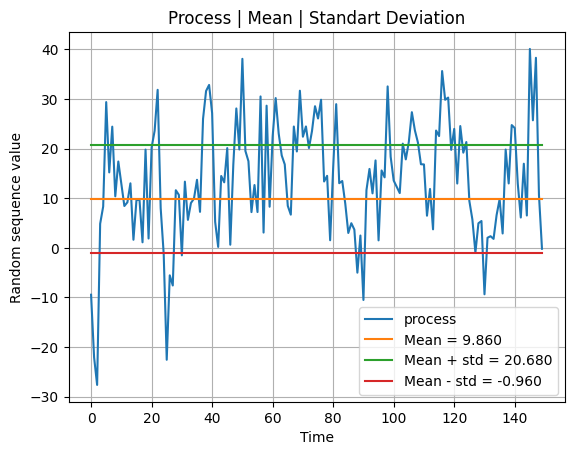

In [5]:
def plot_process(process):
    I = np.arange(150)
    m = mean(process)
    d = var(process)
    s = std(process)
    MX1 = np.full(I.size, m)
    DX1 = MX1 + s * np.ones(I.size)
    DX2 = MX1 - s * np.ones(I.size)
    plt.figure(1)
    plt.plot(process[0:150], label='process')
    plt.plot(MX1, label=f'Mean = {mean(process):.3f}')
    plt.plot(DX1, label=f'Mean + std = {mean(process) + np.std(process):.3f}')
    plt.plot(DX2, label=f'Mean - std = {mean(process) - np.std(process):.3f}')
    #plt.axis([0, 150, 25, 75])
    plt.ylabel('Random sequence value')
    plt.xlabel('Time')
    plt.title('Process | Mean | Standart Deviation')
    plt.legend()
    plt.grid()
    plt.show()

plot_process(process)

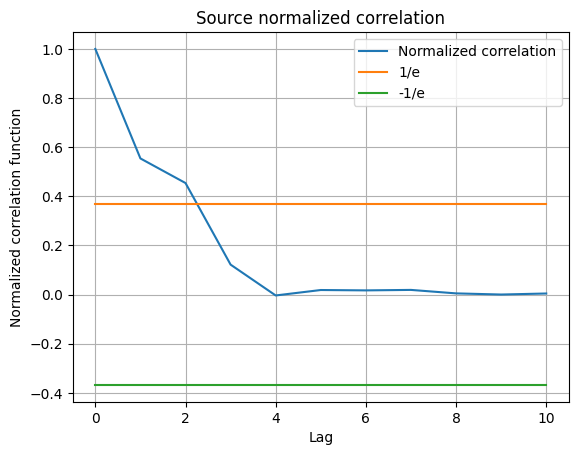

In [6]:
def plot_NCF(K, rX):
    e_plus = np.full(K.size, 1 / np.e)
    e_minus = np.full(K.size, -1 / np.e)
    plt.figure(2)
    plt.plot(K, rX, label='Normalized correlation')
    plt.plot(K, e_plus, label='1/e')
    plt.plot(K, e_minus, label='-1/e')
    plt.xlabel("Lag")
    plt.ylabel("Normalized correlation function")
    plt.title("Source normalized correlation")
    plt.legend()
    plt.grid()
    plt.show()

plot_NCF(np.arange(0, 11), NCF(process))

## Utils

In [7]:
r = NCF(process)
R = CF(process)

In [8]:
def correlation_radius(r):
    for _ in range(1, 11):
        if all(np.abs(r[_+1:]) < np.exp(-1)):
            return _
print(f"Radius of correlation: {correlation_radius(r)}")

Radius of correlation: 2


In [9]:
def MSE(r_true, r_model, amount=10):
    r_true = np.array(r_true)
    r_model = np.array(r_model)
    diff = r_true[:amount] - r_model[:amount]
    msd = np.sum(diff**2)
    return msd

## ARMA class

In [10]:
class ARMA:
    def __init__(self, m, n):
        self.__set_orders(m, n)
        self.beta = np.ones(m)
        self.alpha = np.ones(n + 1)
        self.is_stable = False
        self.model_exists = False
        self.eps = 1e-5
        self.mean = 0
        self.generated_process = np.zeros(5000)
        self.theoretical_cf = np.zeros(150)
        self.theoretical_ncf = np.zeros(11)


    def load_data(self, data):
        self.data = data
        self.ree = np.zeros(self.n + 1)
        self.cf = self.__cf()

    def __set_orders(self, m, n):
        if m < 0 or n < 0:
            raise ValueError("Порядок AR и MA должен быть больше 0")
        self.m = m
        self.n = n

    def __cf(self):
        xS = np.mean(self.data)
        return np.array([(self.data[:len(self.data)-k] - xS) @ (self.data[k:] - xS) / (len(self.data) - k - 1) for k in range(150)])

    def __beta_n_m(self, beta, n, m):
        return sum(beta[i] * self.cf[abs(n - i)] for i in range(m)) - self.cf[n + m - self.m + 1]

    def __get_beta(self, beta):
        return [self.__beta_n_m(beta, self.n + m, self.m) for m in range(self.m)]

    def __ree_n_m(self, alpha, n):
        limit = min(n, self.m)
        return sum(self.beta[i] * self.ree[abs(n - i - 1)] for i in range(limit)) + alpha[n]

    def __get_cf_ree(self, alpha):
        for i in range(self.n + 1):
            self.ree[i] = self.__ree_n_m(alpha, i)
        return self.ree

    def __rn_n_m(self, alpha, n, m):
        return sum(self.beta[i] * self.cf[abs(n - i - 1)] for i in range(0, m)) + sum(alpha[n + j] * self.ree[j] for j in range(0, self.n - n + 1)) - self.cf[n]

    def __get_alpha(self, alpha):
        self.__get_cf_ree(alpha)
        return [self.__rn_n_m(alpha, i, self.m) for i in range(self.n + 1)]

    def __solve_alpha(self):
        self.alpha = fsolve(self.__get_alpha, self.alpha)

    def __solve_beta(self):
        self.beta = fsolve(self.__get_beta, self.beta)

    def __check_stability(self):
        if self.m == 1:
            self.is_stable = np.abs(self.beta[0]) < 1
        elif self.m == 2:
            self.is_stable = (abs(self.beta[1]) < 1) and (abs(self.beta[0]) < 1 - self.beta[1])
        elif self.m == 3:
            cond1 = abs(self.beta[2]) < 1
            cond2 = abs(self.beta[0] + self.beta[2]) < 1 - self.beta[1]
            cond3 = abs(self.beta[1] + self.beta[1] * self.beta[2]) < abs(1 - self.beta[2]**2)
            self.is_stable = cond1 and cond2 and cond3
        else:
            system = signal.dlti(self.beta, [1], dt=1)
            self.is_stable = all(np.abs(system.poles) < 1)

    def __check_existence(self):
        self.model_exists = np.max(np.abs(self.__get_alpha(self.alpha))) <= self.eps   

    def __null_model(self):
        self.alpha[0] = np.sqrt(self.cf[0])

    def __get_mean(self):
        self.mean = np.mean(self.data) * (1 - np.sum(self.beta))

    def __count_cf(self):
        cf = self.__cf()
        for i in range(self.n + self.m + 1):
            self.theoretical_cf[i] = cf[i]
        for i in range(self.n + self.m, 149):
            self.theoretical_cf[i + 1] = sum(self.theoretical_cf[i - j] * self.beta[j] for j in range(self.m)) if self.m > 0 else 0

    def model_process(self, length=5000):
        self.__get_mean()
        ksi = np.random.normal(0, 1, int(length * 1.2))
        self.generated_process = np.zeros(int(length * 1.2))
        for t in range(self.m, len(self.generated_process)):
            self.generated_process[t] = sum(self.beta[i] * self.generated_process[t - i - 1] for i in range(self.m)) + \
                sum(self.alpha[i] * ksi[t - i] for i in range(self.n + 1)) + self.mean

        self.generated_process = self.generated_process[int(0.2 * length):]
        return self.generated_process

    def __ncf(self, cf):
        return np.array([cf[i] / cf[0] for i in range(0, 11)])
    
    def model_error(self, error_function):
        self.__count_cf()
        original_ncf = self.__ncf(self.cf)
        simulated_ncf = self.__ncf(self.theoretical_cf)
        return error_function(original_ncf, simulated_ncf)

    def plot_norm_corr_functions(self):
        if not hasattr(self, 'data'):
            raise ValueError("Исходные данные не загружены. Вызовите load_data() перед построением.")

        self.__count_cf()
        xS = np.mean(self.generated_process)
        simulated_ncf = self.__ncf(np.array(
            [(self.generated_process[:len(self.generated_process)-k] - xS) @ (self.generated_process[k:] - xS) / (len(self.generated_process) - k - 1) for k in range(150)]
        ))
        original_ncf = self.__ncf(self.cf)
        theoretical_ncf = self.__ncf(self.theoretical_cf)

        plt.figure(figsize=(8, 4))
        plt.plot(original_ncf, label='Original NCF')
        plt.plot(simulated_ncf, label='Simulated NCF')
        plt.plot(theoretical_ncf, label=f'ARMA({self.m}, {self.n}) NCF')
        plt.xlabel('Lag')
        plt.ylabel('Value')
        plt.title('NCF')
        plt.legend()
        plt.grid(True)
        plt.show()
        print(f'Original NCF: {original_ncf}')
        print(f'Simulated NCF: {simulated_ncf}')
        print(f'Theoretical NCF: {theoretical_ncf}')

    def count_theoretical_ncf(self):
        self.__count_cf()
        self.theoretical_ncf = self.__ncf(self.theoretical_cf)
        return self.theoretical_ncf


    def count_simulated_process_ncf(self):
        self.model_process()
        xS = np.mean(self.generated_process)
        return self.__ncf(np.array(
            [(self.generated_process[:len(self.generated_process)-k] - xS) @ (self.generated_process[k:] - xS) / (len(self.generated_process) - k - 1) for k in range(150)]
        ))

    @staticmethod
    def plot_process(process, length=150, start=0):        
        segment = process[start:start + length]
        mean_val = np.mean(segment)
        std_val = np.std(segment)
        plt.figure(figsize=(10, 4))
        plt.axhline(mean_val + std_val, color='red', linestyle=':', label=f"Mean + Std ({mean_val + std_val:.3f})")
        plt.axhline(mean_val, color='green', linestyle='--', label=f"Mean ({mean_val:.3f})")
        plt.axhline(mean_val - std_val, color='red', linestyle=':', label=f"Mean - Std ({mean_val - std_val:.3f})")
        plt.plot(segment, label="ARMA process")
        plt.title(f"ARMA process from {start} to {start + length}")
        plt.xlabel("t")
        plt.ylabel("Value")
        plt.grid(True)
        plt.legend()
        plt.show()

    def exists_and_stable(self):
        return self.model_exists and self.is_stable

    def fit(self):
        if self.m == 0 and self.n > 0:
            self.__solve_alpha()
            self.__check_existence()
        elif self.m > 0 or self.n > 0:
            self.__solve_beta()
            self.__check_stability()
            self.__solve_alpha()
            self.__check_existence()
        else:
            self.__null_model()


# Models overview

## Utils

In [11]:
def test_models(models, process):
    for _, model in models.items():
        model.load_data(process)
        model.fit()
        print("==========================================================")
        print(f"Model: {_}")
        print(f"beta: {model.beta}")
        print(f"alpha: {model.alpha}")
        print(f"Is stable: {model.is_stable}")
        print(f"Model exists: {model.model_exists}")

## Models tables

In [12]:
def create_ar_dataframe(models, error):
    data = {
        'M': [model.m for model in models.values()],
        'B1': [model.beta[0] if model.is_stable else "Unstable" for model in models.values()],
        'B2': [(model.beta[1] if model.m > 1 else np.nan) if model.is_stable else "Unstable" for model in models.values()],
        'B3': [(model.beta[2] if model.m > 2 else np.nan) if model.is_stable else "Unstable" for model in models.values()],
        'A0': [model.alpha[0] if model.is_stable else "Unstable" for model in models.values()],
        'error': error,
    }
    df = pd.DataFrame(data, columns=['M', 'B1', 'B2', 'B3', 'A0', 'error'])
    df.set_index(['M'], inplace=True)
    return df

def create_ma_dataframe(models, error):
    data = {
        'N': [model.n for model in models.values()],
        'A0': [model.alpha[0] if model.model_exists else "Model not exists" for model in models.values()],
        'A1': [model.alpha[1] if model.model_exists else "Model not exists" for model in models.values()],
        'A2': [(model.alpha[2] if model.n > 1 else np.nan) if model.model_exists else "Model not exists" for model in models.values()],
        'A3': [(model.alpha[3] if model.n > 2 else np.nan) if model.model_exists else "Model not exists" for model in models.values()],
        'error': error,
    }
    df = pd.DataFrame(data, columns=['N', 'A0', 'A1', 'A2', 'A3', 'error'])
    df.set_index(['N'], inplace=True)
    return df

def create_arma_dataframe(models, error):
    data = {
        'M': [model.m for model in models.values()],
        'N': [model.n for model in models.values()],
        'B1': [model.beta[0] if model.exists_and_stable() else ("Unstable" if not model.is_stable else "Model not exists") for model in models.values()],
        'B2': [(model.beta[1] if model.m > 1 else np.nan) if model.exists_and_stable() else ("Unstable" if not model.is_stable else "Model not exists") for model in models.values()],
        'B3': [(model.beta[2] if model.m > 2 else np.nan) if model.exists_and_stable() else ("Unstable" if not model.is_stable else "Model not exists") for model in models.values()],
        'A0': [model.alpha[0] if model.exists_and_stable() else ("Unstable" if not model.is_stable else "Model not exists") for model in models.values()],
        'A1': [model.alpha[1] if model.exists_and_stable() else ("Unstable" if not model.is_stable else "Model not exists") for model in models.values()],
        'A2': [(model.alpha[2] if model.n > 1 else np.nan) if model.exists_and_stable() else ("Unstable" if not model.is_stable else "Model not exists") for model in models.values()],
        'A3': [(model.alpha[3] if model.n > 2 else np.nan) if model.exists_and_stable() else ("Unstable" if not model.is_stable else "Model not exists") for model in models.values()],
        'error': error,
    }
    df = pd.DataFrame(data, columns=['M', 'N', 'B1', 'B2', 'B3', 'A0', 'A1', 'A2', 'A3', 'error'])
    df.set_index(['M', 'N'], inplace=True)
    return df

## All models

In [13]:
ar_models = {
    'AR(0)': ARMA(0, 0),
    'AR(1)': ARMA(1, 0),
    'AR(2)': ARMA(2, 0),
    'AR(3)': ARMA(3, 0),
}

ma_models = {
    'MA(0)': ARMA(0, 0),
    'MA(1)': ARMA(0, 1),
    'MA(2)': ARMA(0, 2),
    'MA(3)': ARMA(0, 3),
}

arma_models = {
    'ARMA(1, 1)': ARMA(1, 1),
    'ARMA(1, 2)': ARMA(1, 2),
    'ARMA(1, 3)': ARMA(1, 3),
    'ARMA(2, 1)': ARMA(2, 1),
    'ARMA(2, 2)': ARMA(2, 2),
    'ARMA(2, 3)': ARMA(2, 3),
    'ARMA(3, 1)': ARMA(3, 1),
    'ARMA(3, 2)': ARMA(3, 2),
    'ARMA(3, 3)': ARMA(3, 3),
}

## AR models

In [14]:
test_models(ar_models, process)

Model: AR(0)
beta: []
alpha: [10.82098253]
Is stable: False
Model exists: False
Model: AR(1)
beta: [0.554177]
alpha: [9.00737346]
Is stable: True
Model exists: True
Model: AR(2)
beta: [0.4367292  0.21193193]
alpha: [8.80276585]
Is stable: True
Model exists: True
Model: AR(3)
beta: [ 0.49878515  0.33981093 -0.29281075]
alpha: [8.41694428]
Is stable: True
Model exists: True


In [15]:
ar_errors = [
    ar_models['AR(0)'].model_error(MSE),
    ar_models['AR(1)'].model_error(MSE) if ar_models['AR(1)'].is_stable else np.nan,
    ar_models['AR(2)'].model_error(MSE) if ar_models['AR(1)'].is_stable else np.nan,
    ar_models['AR(3)'].model_error(MSE) if ar_models['AR(3)'].is_stable else np.nan,
]

table_ar = create_ar_dataframe(ar_models, ar_errors)
table_ar

,B1,B2,B3,A0,error
M,,,,,
0,Unstable,Unstable,Unstable,Unstable,0.529083
1,0.554177,NaN,NaN,9.007373,0.034809
2,0.436729,0.211932,NaN,8.802766,0.139003
3,0.498785,0.339811,-0.292811,8.416944,0.022973


## MA models

In [16]:
test_models(ma_models, process)

Model: MA(0)
beta: []
alpha: [10.82098253]
Is stable: False
Model exists: False
Model: MA(1)
beta: []
alpha: [7.73411404 7.73364293]
Is stable: False
Model exists: False
Model: MA(2)
beta: []
alpha: [7.03695816 4.50695504 7.03836715]
Is stable: False
Model exists: False
Model: MA(3)
beta: []
alpha: [1.75987747 5.68960419 3.97596153 8.11274481]
Is stable: False
Model exists: True


In [17]:
ma_errors = [
    ma_models['MA(0)'].model_error(MSE),
    ma_models['MA(1)'].model_error(MSE) if ma_models['MA(1)'].model_exists else np.nan,
    ma_models['MA(2)'].model_error(MSE) if ma_models['MA(2)'].model_exists else np.nan,
    ma_models['MA(3)'].model_error(MSE) if ma_models['MA(3)'].model_exists else np.nan,
]

table_ma = create_ma_dataframe(ma_models, ma_errors)
table_ma

,A0,A1,A2,A3,error
N,,,,,
0,Model not exists,Model not exists,Model not exists,Model not exists,0.529083
1,Model not exists,Model not exists,Model not exists,Model not exists,NaN
2,Model not exists,Model not exists,Model not exists,Model not exists,NaN
3,1.759877,5.689604,3.975962,8.112745,0.001026


## ARMA models

In [18]:
test_models(arma_models, process)

Model: ARMA(1, 1)
beta: [0.81915562]
alpha: [ 8.76487455 -3.53996139]
Is stable: True
Model exists: True
Model: ARMA(1, 2)
beta: [0.26859748]
alpha: [4.31814791 1.89361111 8.27346742]
Is stable: True
Model exists: True
Model: ARMA(1, 3)
beta: [-0.02928695]
alpha: [5.3956882  3.22076372 8.53793487 2.93460239]
Is stable: True
Model exists: True
Model: ARMA(2, 1)
beta: [-0.88284128  0.94320753]
alpha: [ 9.32570295 11.48014443]
Is stable: False
Model exists: True
Model: ARMA(2, 2)
beta: [ 0.41392457 -0.1190455 ]
alpha: [4.92318861 0.57219103 8.17258262]
Is stable: True
Model exists: True
Model: ARMA(2, 3)
beta: [-0.5350403   0.13584408]
alpha: [5.31433066 6.15606248 9.5656213  6.37949996]
Is stable: True
Model exists: True
Model: ARMA(3, 1)
beta: [ 0.78974195  0.2127416  -0.35447379]
alpha: [ 8.37613853 -2.69167715]
Is stable: True
Model exists: True
Model: ARMA(3, 2)
beta: [ 0.30757515 -0.21293516  0.10030958]
alpha: [6.68927161 1.49127408 7.71698058]
Is stable: True
Model exists: True
Mo

In [19]:
arma_errors = [
    arma_models['ARMA(1, 1)'].model_error(MSE) if arma_models['ARMA(1, 1)'].exists_and_stable() else np.nan,
    arma_models['ARMA(1, 2)'].model_error(MSE) if arma_models['ARMA(1, 2)'].exists_and_stable() else np.nan,
    arma_models['ARMA(1, 3)'].model_error(MSE) if arma_models['ARMA(1, 3)'].exists_and_stable() else np.nan,
    arma_models['ARMA(2, 1)'].model_error(MSE) if arma_models['ARMA(2, 1)'].exists_and_stable() else np.nan,
    arma_models['ARMA(2, 2)'].model_error(MSE) if arma_models['ARMA(2, 2)'].exists_and_stable() else np.nan,
    arma_models['ARMA(2, 3)'].model_error(MSE) if arma_models['ARMA(2, 3)'].exists_and_stable() else np.nan,
    arma_models['ARMA(3, 1)'].model_error(MSE) if arma_models['ARMA(3, 1)'].exists_and_stable() else np.nan,
    arma_models['ARMA(3, 2)'].model_error(MSE) if arma_models['ARMA(3, 2)'].exists_and_stable() else np.nan,
    arma_models['ARMA(3, 3)'].model_error(MSE) if arma_models['ARMA(3, 3)'].exists_and_stable() else np.nan,    
]

table_arma = create_arma_dataframe(
    models=arma_models,
    error=arma_errors,
)
table_arma

B1        B2        B3        A0        A1        A2        A3  \
M N                                                                         
1 1  0.819156       NaN       NaN  8.764875 -3.539961       NaN       NaN   
  2  0.268597       NaN       NaN  4.318148  1.893611  8.273467       NaN   
  3 -0.029287       NaN       NaN  5.395688  3.220764  8.537935  2.934602   
2 1  Unstable  Unstable  Unstable  Unstable  Unstable  Unstable  Unstable   
  2  0.413925 -0.119045       NaN  4.923189  0.572191  8.172583       NaN   
  3  -0.53504  0.135844       NaN  5.314331  6.156062  9.565621    6.3795   
3 1  0.789742  0.212742 -0.354474  8.376139 -2.691677       NaN       NaN   
  2  0.307575 -0.212935   0.10031  6.689272  1.491274  7.716981       NaN   
  3  0.259029 -0.192841   0.09453   0.29433  7.797633  1.832852  6.636353   

        error  
M N            
1 1  0.298107  
  2  0.001985  
  3  0.001010  
2 1       NaN  
  2  0.002130  
  3  0.000994  
3 1  0.095891  
  2  0.000352  
  3  0.000380

## Best models

In [20]:
def get_best_model(models, loss_function):
    best_model = None
    model_name = None
    for _, model in models.items():
        if model.n == 0:
            if model.is_stable or model.m == 0:
                if best_model is None or model.model_error(loss_function) < best_model.model_error(loss_function):
                    best_model = model
                    model_name = _
        elif model.m == 0:
            if model.model_exists or model.n == 0:
                if best_model is None or model.model_error(loss_function) < best_model.model_error(loss_function):
                    best_model = model
                    model_name = _
        else:
            if model.exists_and_stable():
                if best_model is None or model.model_error(loss_function) < best_model.model_error(loss_function):
                    best_model = model
                    model_name = _
    return model_name, best_model

In [21]:
ar_name, ar_best_model = get_best_model(ar_models, MSE)
ma_name, ma_best_model = get_best_model(ma_models, MSE)
arma_name, arma_best_model = get_best_model(arma_models, MSE)

best_models = {
    ar_name: ar_best_model,
    ma_name: ma_best_model,
    arma_name: arma_best_model,
}

In [22]:
print("==========================================================")
print(f"Best AR model: {ar_name}")
print(f"Best MA model: {ma_name}")
print(f"Best ARMA model: {arma_name}")
print("==========================================================")

Best AR model: AR(3)
Best MA model: MA(3)
Best ARMA model: ARMA(3, 2)


In [23]:
def best_model_parameters_dataframe():
    index = ['M(ξ)', 'D(ξ)', '√(D(ξ))']
    columns = pd.MultiIndex.from_tuples([
        ('Source process', ''),
        (ar_name, 'Source'),
        (ar_name, 'Simulated'),
        (ma_name, 'Source'),
        (ma_name, 'Simulated'),
        (arma_name, 'Source'),
        (arma_name, 'Simulated'),
    ])
    data = np.array([
        [ np.mean(process), np.var(process), np.std(process), ],
        [ ar_best_model.mean, np.var(ar_best_model.data), np.std(ar_best_model.data), ],
        [ np.mean(ar_best_model.generated_process), np.var(ar_best_model.generated_process), np.std(ar_best_model.generated_process), ],
        [ ma_best_model.mean, np.var(ma_best_model.data), np.std(ma_best_model.data), ],
        [ np.mean(ma_best_model.generated_process), np.var(ma_best_model.generated_process), np.std(ma_best_model.generated_process), ],
        [ arma_best_model.mean, np.var(arma_best_model.data), np.std(arma_best_model.data), ],
        [ np.mean(arma_best_model.generated_process), np.var(arma_best_model.generated_process), np.std(arma_best_model.generated_process), ],
    ])
    data = data.T
    df = pd.DataFrame(data, index=index, columns=columns)
    return df

def best_models_ncf_dataframe():
    index = [f'r({i})' for i in range(11)] + ['Error']

    columns = pd.MultiIndex.from_tuples([
        ('Source process', ''),
        (ar_name, 'Source'),
        (ar_name, 'Simulated'),
        (ma_name, 'Source'),
        (ma_name, 'Simulated'),
        (arma_name, 'Source'),
        (arma_name, 'Simulated'),
    ])

    data = [
        r.tolist() + [0],
        ar_best_model.count_theoretical_ncf().tolist() + [MSE(r, ar_best_model.count_theoretical_ncf())],
        ar_best_model.count_simulated_process_ncf().tolist() + [MSE(r, ar_best_model.count_simulated_process_ncf())],
        ma_best_model.count_theoretical_ncf().tolist() + [MSE(r, ma_best_model.count_theoretical_ncf())],
        ma_best_model.count_simulated_process_ncf().tolist() + [MSE(r, ma_best_model.count_simulated_process_ncf())],
        arma_best_model.count_theoretical_ncf().tolist() + [MSE(r, arma_best_model.count_theoretical_ncf())],
        arma_best_model.count_simulated_process_ncf().tolist() + [MSE(r, arma_best_model.count_simulated_process_ncf())],
    ]

    data = np.array(data).T

    df = pd.DataFrame(data, index=index, columns=columns)
    return df

In [24]:
ar_best_model.model_process(5000)
ma_best_model.model_process(5000)
arma_best_model.model_process(5000)
best_model_parameters_dataframe()

Source process       AR(3)                   MA(3)              \
                            Source   Simulated      Source   Simulated   
M(ξ)          9.859880    4.478502    9.959751    9.859880    9.764246   
D(ξ)        117.070244  117.070244  111.911329  117.070244  120.328061   
√(D(ξ))      10.819900   10.819900   10.578815   10.819900   10.969415   

         ARMA(3, 2)              
             Source   Simulated  
M(ξ)       7.937701    9.635316  
D(ξ)     117.070244  122.383077  
√(D(ξ))   10.819900   11.062688

In [25]:
best_models_ncf_dataframe()

Source process     AR(3)               MA(3)           ARMA(3, 2)  \
                        Source Simulated    Source Simulated     Source   
r(0)        0.999977  1.000000  1.000000  1.000000  1.000000   1.000000   
r(1)        0.554129  0.554177  0.549169  0.554177  0.565127   0.554177   
r(2)        0.453994  0.453957  0.454099  0.453957  0.444300   0.453957   
r(3)        0.121866  0.121932  0.128620  0.121932  0.103412   0.121932   
r(4)       -0.003680  0.052808  0.081613  0.000000 -0.016676  -0.003571   
r(5)        0.018477 -0.065150 -0.037038  0.000000 -0.011985   0.018474   
r(6)        0.016959 -0.050254 -0.009176  0.000000  0.001010   0.018674   
r(7)        0.018922 -0.062667 -0.031302  0.000000  0.000515   0.001451   
r(8)        0.004761 -0.029258 -0.009771  0.000000 -0.000547  -0.001677   
r(9)        0.000110 -0.021174 -0.019549  0.000000 -0.000510   0.001048   
r(10)       0.004298 -0.002153 -0.013800  0.000000 -0.012463   0.000825   
Error       0.000000  0.022969  0.019534  0.001023  0.002012   0.000351   

                 
      Simulated  
r(0)   1.000000  
r(1)   0.565148  
r(2)   0.463367  
r(3)   0.135735  
r(4)  -0.005238  
r(5)  -0.000251  
r(6)   0.004852  
r(7)  -0.009956  
r(8)   0.000211  
r(9)   0.015203  
r(10)  0.007800  
Error  0.006638

# Modelling Process

## AR(...)

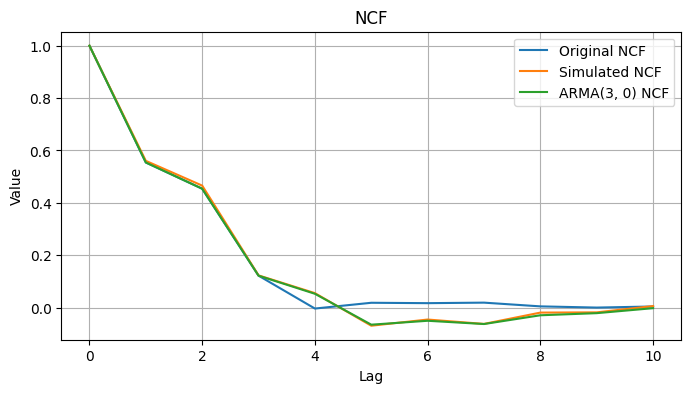

Original NCF: [ 1.00000000e+00  5.54177000e-01  4.53957205e-01  1.21931763e-01
 -3.57100910e-03  1.84743419e-02  1.70002691e-02  1.89895319e-02
  4.73896319e-03  1.39834690e-04  4.27226798e-03]
Simulated NCF: [ 1.          0.56032679  0.46583901  0.12305322  0.05525749 -0.06914843
 -0.04554695 -0.06224443 -0.0190249  -0.01814809  0.0059066 ]
Theoretical NCF: [ 1.          0.554177    0.45395721  0.12193176  0.05280839 -0.06514976
 -0.0502538  -0.06266731 -0.02925776 -0.02117352 -0.00215348]


In [26]:
ar_process = ar_best_model.model_process(5000)
ar_best_model.plot_norm_corr_functions()

## MA(...)

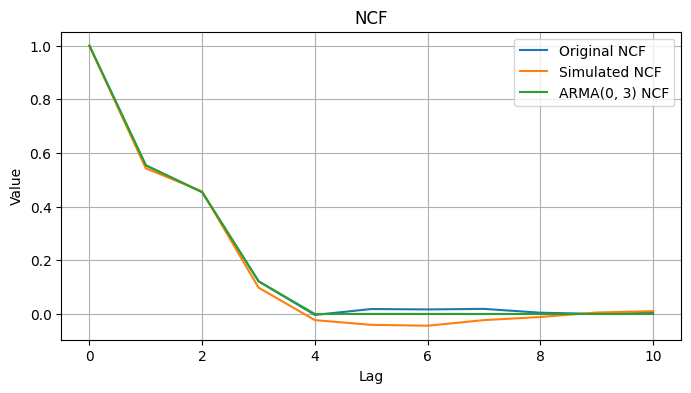

Original NCF: [ 1.00000000e+00  5.54177000e-01  4.53957205e-01  1.21931763e-01
 -3.57100910e-03  1.84743419e-02  1.70002691e-02  1.89895319e-02
  4.73896319e-03  1.39834690e-04  4.27226798e-03]
Simulated NCF: [ 1.          0.54284263  0.45667792  0.09812887 -0.02291485 -0.04051026
 -0.04378579 -0.02283666 -0.01122186  0.00542461  0.01052733]
Theoretical NCF: [1.         0.554177   0.45395721 0.12193176 0.         0.
 0.         0.         0.         0.         0.        ]


In [27]:
ma_process = ma_best_model.model_process(5000)
ma_process = ma_best_model.plot_norm_corr_functions()

## ARMA(...)

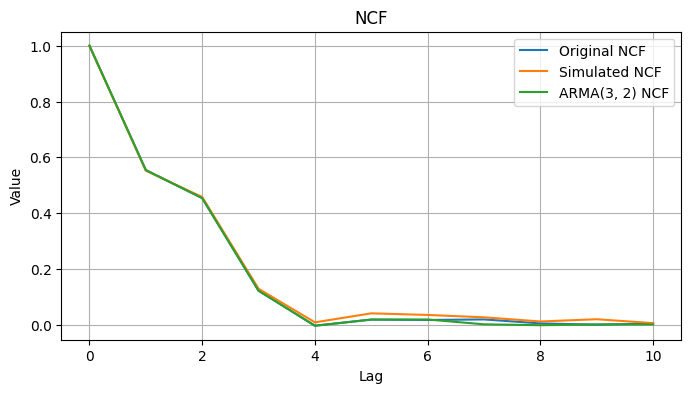

Original NCF: [ 1.00000000e+00  5.54177000e-01  4.53957205e-01  1.21931763e-01
 -3.57100910e-03  1.84743419e-02  1.70002691e-02  1.89895319e-02
  4.73896319e-03  1.39834690e-04  4.27226798e-03]
Simulated NCF: [1.         0.5522553  0.45774047 0.12888579 0.00852777 0.04081296
 0.03508491 0.02658552 0.01164781 0.01969081 0.00567071]
Theoretical NCF: [ 1.00000000e+00  5.54177000e-01  4.53957205e-01  1.21931763e-01
 -3.57100910e-03  1.84743419e-02  1.86735653e-02  1.45148128e-03
 -1.67666560e-03  1.04836536e-03  8.25069656e-04]


In [28]:
arma_process = arma_best_model.model_process(5000)
arma_best_model.plot_norm_corr_functions()

## Best model

In [29]:
def get_best_simulation():
    name = None
    best_model = None
    for model_name, model in best_models.items():
        if name == None or MSE(r, model.count_simulated_process_ncf()) < MSE(r, best_model.count_simulated_process_ncf()):
            best_model = model
            name = model_name
    return name, best_model

Best model: MA(3)


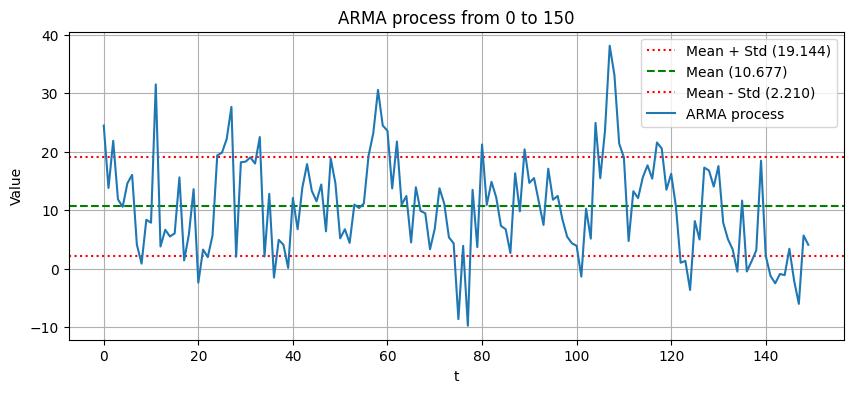

In [30]:
model_name, model = get_best_simulation()
final_process = model.model_process(5000)
print(f"Best model: {model_name}")
model.plot_process(final_process, length=150, start=0)